In [1]:
import numpy as np
import pandas as pd
import pickle
from utils import load_Germany_data, decompose_Y, generate_simulation_components, parallel_experiments, SC_weights

In [2]:
data_dict = {}
RMSE = {}
bias = {}

# set n_jobs to the number of cores
num_cores = 36
num_experiments = 1000

## Load and Format Data

In [31]:
# configs = {'Simulated': ['gdp', None, None],
#            'Random': ['gdp', None, 'Random']
#           }

# TROP_dict = {'Simulated': [0.2, 0.2, 0.0111],
#     'Random': [1.2, 0.2, 0.0111]
#             }

configs = {'Random': ['gdp', None, 'Random'],
          }

TROP_dict = {'Random': [0.6, 0.2, 0.015],
            }

for setting, config in configs.items():
    
    print(setting)
    
    # load and process data for each setting
    outcome, treatment, option = config
    data = load_Germany_data(outcome, treatment)
    data_dict[setting] = data
    
    # run simulations
    simulation_components = generate_simulation_components(data, sc_weights=False)
    np.random.seed(0)
    RMSE[setting], bias[setting] = parallel_experiments(num_cores, num_experiments, simulation_components, TROP_dict[setting], option)

Random


In [32]:
RMSE

{'Random': array([0.05375057, 0.08046621, 0.10251596, 0.14753987, 0.07292822,
        0.09517931])}

In [33]:
bias

{'Random': array([0.00194477, 0.00948719, 0.00083272, 0.0107554 , 0.00339394,
        0.0033089 ])}

# Optimal Tuning Parameter

In [49]:
from methods import TROP_TWFE_average
from utils import generate_data
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [50]:
np.random.seed(1)
outcome, treatment, option = ['gdp', None, 'Random']
data = load_Germany_data(outcome, treatment)
F, M, cov_mat, pi = generate_simulation_components(data, sc_weights=False)

In [51]:
#Y_true, _, _, _ = generate_data(F, M, cov_mat, pi, option)
treated_periods = 1
treated_unit_number = 1

In [52]:
def get_ATE(trial, lambda_unit, lambda_time, lambda_nn):
    np.random.seed(trial)
    Y_true, _, treated_units, _ = generate_data(F, M, cov_mat, pi, option)
    
    Y_true = np.delete(Y_true, treated_units, axis=0)
    N_total, _ = Y_true.shape
    test_units = np.random.choice(np.arange(N_total), size=treated_unit_number,replace=False)
    #test_units = np.arange(N_total)
    
    W_test = np.zeros(Y_true.shape)
    W_test[test_units,-treated_periods:] = 1
    estimate = TROP_TWFE_average(Y_true,W_test, test_units,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn, treated_periods=treated_periods)
    return estimate

## Select lambda_unit

In [96]:
Q = []
lambda_units = np.arange(0,3,3/20)
for lambda_unit in lambda_units:
    lambda_time = 0
    lambda_nn = 0.025
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(50))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0.0 0 0.025
0.052646083406542074
0.15 0 0.025
0.05264609311896575
0.3 0 0.025
0.052646091275399334
0.44999999999999996 0 0.025
0.052646059966883714
0.6 0 0.025
0.05264598678153735
0.75 0 0.025
0.05264605012867289
0.8999999999999999 0 0.025
0.05264618074842899
1.05 0 0.025
0.052632046230854726
1.2 0 0.025
0.052501897583461396
1.3499999999999999 0 0.025
0.05217507942920781
1.5 0 0.025
0.051846026996254416
1.65 0 0.025
0.05157916127519225
1.7999999999999998 0 0.025
0.051371459583364885
1.95 0 0.025
0.05121327157742236
2.1 0 0.025
0.05132163839692527
2.25 0 0.025
0.05153686134656935
2.4 0 0.025
0.051826922303511457
2.55 0 0.025
0.052187292940612584
2.6999999999999997 0 0.025
0.052482515727768166
2.85 0 0.025
0.05282174164370883


In [97]:
lambda_units[np.argmin(Q)]

1.95

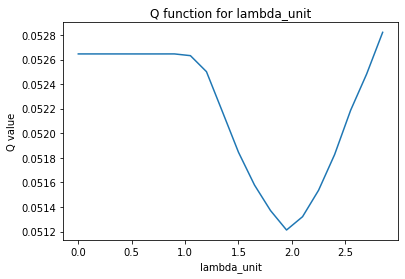

In [98]:
plt.plot(lambda_units,Q)
plt.xlabel('lambda_unit')
plt.ylabel('Q value')
plt.title('Q function for lambda_unit')
plt.show()

## Select lambda_time

In [66]:
Q = []
lambda_times = np.arange(0,5,5/10)
for lambda_time in lambda_times:
    lambda_nn = 0.005
    lambda_unit = 0.
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0 0.0 0.005
0.05416206453311601
0 0.5 0.005
0.03968633456688869
0 1.0 0.005
0.036085414375034146
0 1.5 0.005
0.03484102940075942
0 2.0 0.005
0.03469683605602166
0 2.5 0.005
0.03464858412749478
0 3.0 0.005
0.03463145286418373
0 3.5 0.005
0.034625270662801286
0 4.0 0.005
0.03462296360195999
0 4.5 0.005
0.03462212346079438


In [67]:
lambda_times[np.argmin(Q)]

4.5

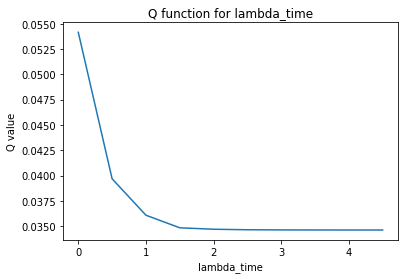

In [68]:
plt.plot(lambda_times,Q)
plt.xlabel('lambda_time')
plt.ylabel('Q value')
plt.title('Q function for lambda_time')
plt.show()

### Select lambad_nn

In [99]:
Q = []
lambda_nns = np.arange(0.005,0.205,0.2/10)
for lambda_nn in lambda_nns:
    lambda_time = 0
    lambda_unit = 1.95
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

1.95 0 0.005
0.05406692843719627
1.95 0 0.025
0.053243365750306054
1.95 0 0.045
0.05418493212643885
1.95 0 0.065
0.05556032098437837
1.95 0 0.085
0.05724303060609508
1.95 0 0.10500000000000001
0.05875152539740538
1.95 0 0.125
0.06058876706356546
1.95 0 0.14500000000000002
0.062317195854227
1.95 0 0.165
0.0642136607216638
1.95 0 0.185
0.06633390467491455


In [100]:
lambda_nns[np.argmin(Q)]

0.025

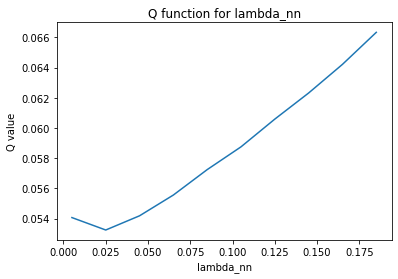

In [101]:
plt.plot(lambda_nns,Q)
plt.xlabel('lambda_nn')
plt.ylabel('Q value')
plt.title('Q function for lambda_nn')
plt.show()